In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import datetime as dt
from datetime import datetime
import pandas_datareader as pdr
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

## Importing our data

In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 1, 1)
sq = pdr.DataReader('TSLA', 'stooq', start_date, end_date)
sq

,Open,High,Low,Close,Volume
Date,,,,,
2022-12-30,119.9500,124.4800,119.7500,123.1800,157777339
2022-12-29,120.3850,123.5700,117.4950,121.8200,221923313
2022-12-28,110.3500,116.2700,108.2400,112.7100,221070537
2022-12-27,117.4950,119.6700,108.7600,109.1000,208643444
2022-12-23,126.3700,128.6173,121.0200,123.1500,166989688
...,...,...,...,...,...
2020-01-08,31.5800,33.2333,31.2153,32.8093,467990895
2020-01-07,30.7600,31.4420,30.2237,31.2707,273137070
2020-01-06,29.3647,30.1040,29.3333,30.1027,152362485


## Data Visualization / Exploration

In [3]:
sq.info()
# Notice that Date is not listed here as a column

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2022-12-30 to 2020-01-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    756 non-null    float64
 1   High    756 non-null    float64
 2   Low     756 non-null    float64
 3   Close   756 non-null    float64
 4   Volume  756 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.4 KB


array([[<AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'High'}>],
       [<AxesSubplot: title={'center': 'Low'}>,
        <AxesSubplot: title={'center': 'Close'}>],
       [<AxesSubplot: title={'center': 'Volume'}>, <AxesSubplot: >]],
      dtype=object)

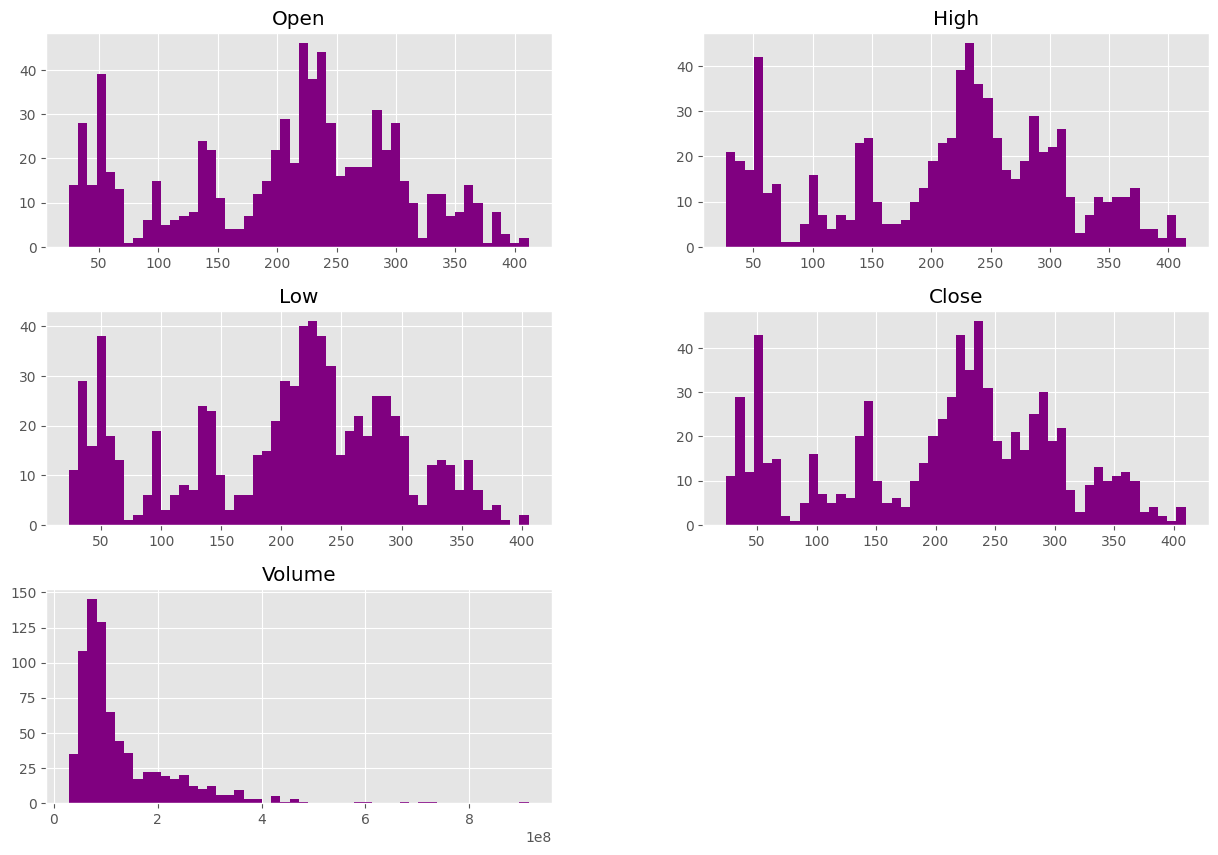

In [4]:
sq.hist(bins=50, figsize=(15,10), color="purple")

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

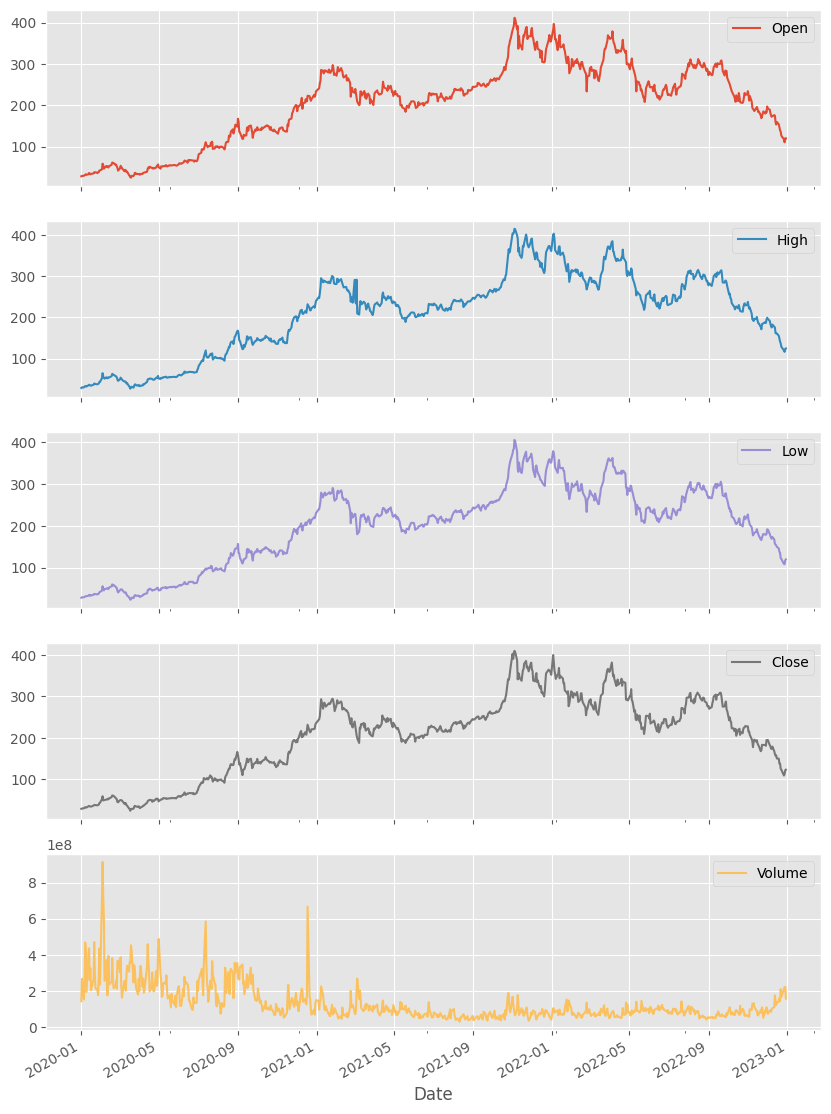

In [5]:
# Plotting all of our column data
sq.plot(legend=True, subplots=True, figsize = (10,15))

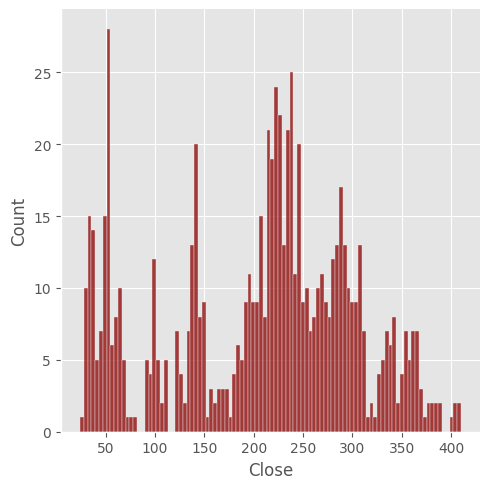

In [6]:
# Plot with nulls dropped
sns.displot(sq["Close"].dropna(), bins=100, color="darkred")

In [7]:
# Stats on each column
sq.describe()

,Open,High,Low,Close,Volume
count,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,206.595090,211.567182,201.220856,206.365503,1.319323e+08
std,96.049344,98.131888,93.701479,95.856970,1.002195e+08
min,24.979700,26.990700,23.367300,24.081300,2.940167e+07
25%,138.633500,141.929750,135.544000,138.270500,6.909451e+07
50%,223.965000,229.393500,218.175000,223.652000,9.439023e+07
75%,278.281500,283.902500,270.410750,276.565250,1.577766e+08
max,411.470000,414.497000,405.667000,409.970000,9.140814e+08


## Preprocessing

In [8]:
# Let's quickly view incomplete rows (if any)
sample_incomplete_rows = sq[sq.isnull().any(axis=1)].head()
sample_incomplete_rows

,Open,High,Low,Close,Volume
Date,,,,,


#### Imputing

In [9]:
# Normally we would want to do this for these kinds of data sets. It seems the data we are pulling really doesn't include null vals most of the time.
# Leaving this step in just in case a situation arises where we have a null value.
sq.reset_index(drop=True, inplace=True)
sq.fillna(sq.mean(), inplace=True)

## Test / Train sets

In [10]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size = 100
for i in range (1, len(sq) - window_size, 1):
    first = sq.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((sq.iloc[i + j, 2] - first) / first)
    temp2.append((sq.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))
print(len(X))
print(len(Y))

655
655


In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0], 100)
test_X = test_X.reshape(test_X.shape[0], 100)
train_Y = train_Y.reshape(train_Y.shape[0])
test_Y = test_Y.reshape(test_Y.shape[0])

print(len(train_X))
print(len(test_X))

524
131


In [12]:
train_X = train_X.reshape(train_X.shape[0],100,1)
test_X = test_X.reshape(test_X.shape[0],100,1)

## Model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(100, 1)))
model.add(Conv1D(128, kernel_size=3, activation="relu"))
model.add(Conv1D(64, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))

model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

result = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=5, batch_size=200, verbose=1, shuffle=True)

Epoch 1/5
3/3 [==============================] - 4s 413ms/step - loss: 0.1250 - mse: 0.1250 - mae: 0.2851 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.2162
Epoch 2/5
3/3 [==============================] - 0s 145ms/step - loss: 0.0492 - mse: 0.0492 - mae: 0.1732 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1210
Epoch 3/5
3/3 [==============================] - 0s 151ms/step - loss: 0.0225 - mse: 0.0225 - mae: 0.1136 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0952
Epoch 4/5
3/3 [==============================] - 0s 148ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.1039 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0717
Epoch 5/5
3/3 [==============================] - 0s 149ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0939 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0810


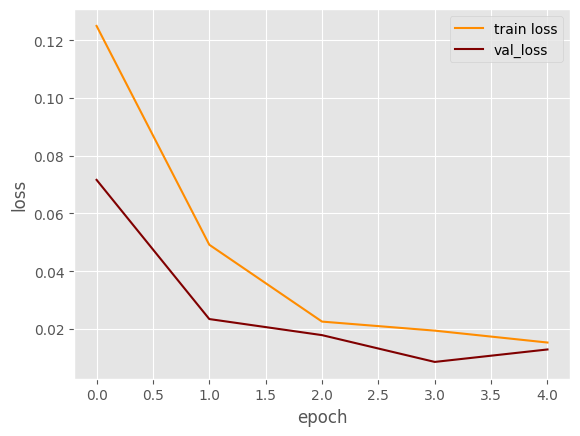

In [14]:
# Plot our loss over each epoch. We see our loss start to plateu after our 5 epochs which usually means that's a good place to stop.
plt.plot(result.history['loss'], label='train loss', color="darkorange")
plt.plot(result.history['val_loss'], label='val_loss', color="maroon")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 64)            24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 200)              99600     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0

In [16]:
model.evaluate(test_X, test_Y)

5/5 [==============================] - 0s 8ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0810


[0.012847129255533218, 0.012847129255533218, 0.08098997175693512]

In [17]:
# Plotting our results
# plt.figure(figsize=(16,8))
# plt.title('Our Model')
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Close Price (USD)', fontsize=14)
# plt.plot(predictions)
# plt.show()